In [1]:
pip install pandas numpy datetime psutil

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math
import psutil
import multiprocessing as mp
import datetime
from datetime import datetime


In [3]:
# I am using Windows Subsystem for Linux on a windows computer, therefore for data loading, I used /mnt. To load in a different environment, you need to specify paths. 

# Convert Windows paths to WSL paths
all_data_path = '/mnt/c/Users/baris/Downloads/all_waybill_info_meituan.csv'
courier_wave_path = '/mnt/c/Users/baris/Downloads/courier_wave_info_meituan.csv'
dispatch_rider_path = '/mnt/c/Users/baris/Downloads/dispatch_rider_meituan.csv'
cars_aggregated_path = '/mnt/c/Users/baris/Downloads/2021_Cars_Aggregated.csv'

# Read CSV files into DataFrames
all_data_df = pd.read_csv(all_data_path)
courier_wave_df = pd.read_csv(courier_wave_path)
dispatch_rider_df = pd.read_csv(dispatch_rider_path)
cars_aggregated_df = pd.read_csv(cars_aggregated_path)

# List of time-related columns in 'all_data_df' that need conversion
time_columns = [
    'estimate_arrived_time', 'dispatch_time', 'grab_time',
    'fetch_time', 'arrive_time', 'order_push_time', 'platform_order_time', 'estimate_meal_prepare_time'
]

# Convert each time-related column from Unix timestamp to datetime
for column in time_columns:
    all_data_df[column] = pd.to_datetime(all_data_df[column], unit='s')

# Convert the 'wave_start_time' and 'wave_end_time' columns from Unix timestamp to datetime
courier_wave_df['wave_start_time'] = pd.to_datetime(courier_wave_df['wave_start_time'], unit='s')
courier_wave_df['wave_end_time'] = pd.to_datetime(courier_wave_df['wave_end_time'], unit='s')

# Convert the 'dispatch_time' column in 'dispatch_rider_df' from Unix timestamp to datetime
dispatch_rider_df['dispatch_time'] = pd.to_datetime(dispatch_rider_df['dispatch_time'], unit='s')


In [4]:
print(cars_aggregated_df.columns)

Index(['Manufacturer', 'Fuel Type', 'Number of vehicles',
       'OBFCM Fuel consumption (l/100 km)', 'WLTP Fuel consumption (l/100 km)',
       'absolute gap Fuel consumption (l/100 km)',
       'percentage gap Fuel consumption (%)', 'OBFCM CO2 emissions (g/km)',
       'WLTP CO2 emissions (g/km)', 'absolute gap CO2 emissions (g/km)',
       'percentage gap CO2 emissions (%)',
       'OBFCM Fuel consumption weighted (l/100 km)',
       'WLTP Fuel consumption weighted (l/100 km)',
       'absolute gap Fuel consumption weighted (l/100 km)',
       'percentage gap Fuel consumption weighted (%)',
       'OBFCM CO2 emissions weighted (g/km)',
       'WLTP CO2 emissions weighted (g/km)',
       'absolute gap CO2 emissions weighted (g/km)',
       'percentage gap CO2 emissions weighted (%)'],
      dtype='object')


In [5]:
# List of time-related columns in 'all_data_df' that need conversion
time_columns = [
    'estimate_arrived_time', 'dispatch_time', 'grab_time',
    'fetch_time', 'arrive_time', 'order_push_time', 'platform_order_time', 'estimate_meal_prepare_time'
]

# Reference date to compare against
reference_date = pd.to_datetime('1970-01-01 00:00:00')

# Drop rows where any time column has the reference date
for column in time_columns:
    all_data_df = all_data_df[all_data_df[column] != reference_date].reset_index(drop=True)

# Ensure 'order_push_time' and 'arrive_time' are in datetime format
all_data_df['order_push_time'] = pd.to_datetime(all_data_df['order_push_time'])
all_data_df['arrive_time'] = pd.to_datetime(all_data_df['arrive_time'])

# Extract the date from 'order_push_time' for grouping
all_data_df['date'] = all_data_df['order_push_time'].dt.date

# Group by 'courier_id' and 'date' to find min 'order_push_time' and max 'arrive_time'
courier_availability = all_data_df.groupby(['courier_id', 'date']).agg(
    min_order_push_time=('order_push_time', 'min'),
    max_arrive_time=('arrive_time', 'max')
).reset_index()

# Separate date and time components
courier_availability['min_order_push_hour'] = courier_availability['min_order_push_time'].dt.hour
courier_availability['max_arrive_hour'] = courier_availability['max_arrive_time'].dt.hour

# Drop the original datetime columns if only time is needed
courier_availability.drop(columns=['min_order_push_time', 'max_arrive_time'], inplace=True)

# Function to adjust time by adding or subtracting hours
def adjust_and_extract_hour(hour, add_hours=0):
    if pd.isna(hour):
        return np.nan
    adjusted_hour = hour + add_hours
    return np.clip(adjusted_hour, 0, 23)  # Ensure valid hour between 0-23

# Apply the adjustment:
# Subtract 1 hour from 'min_order_push_hour'
courier_availability['min_order_push_hour'] = courier_availability['min_order_push_hour'].apply(
    lambda x: adjust_and_extract_hour(x, add_hours=-1)
)

# Add 1 hour to 'max_arrive_hour'
courier_availability['max_arrive_hour'] = courier_availability['max_arrive_hour'].apply(
    lambda x: adjust_and_extract_hour(x, add_hours=1)
)

# Calculate statistics for the specified columns
statistics = courier_availability[['min_order_push_hour', 'max_arrive_hour']].describe()

# Extracting specific statistics
average_min_order_push_hour = statistics.loc['mean', 'min_order_push_hour']
average_max_arrive_hour = statistics.loc['mean', 'max_arrive_hour']
max_min_order_push_hour = statistics.loc['max', 'min_order_push_hour']
max_max_arrive_hour = statistics.loc['max', 'max_arrive_hour']
min_min_order_push_hour = statistics.loc['min', 'min_order_push_hour']
min_max_arrive_hour = statistics.loc['min', 'max_arrive_hour']
std_dev_min_order_push_hour = statistics.loc['std', 'min_order_push_hour']
std_dev_max_arrive_hour = statistics.loc['std', 'max_arrive_hour']


In [6]:
# Define how many times to duplicate
num_duplications = 4

# Create an empty list to store the duplicated DataFrames
duplicated_dfs = []

# Get the max courier_id to start incrementing from
max_courier_id = courier_availability['courier_id'].max()

# Duplicate the DataFrame 'num_duplications' times
for i in range(num_duplications):
    # Make a copy of the original DataFrame
    temp_df = courier_availability.copy()
    
    # Increment the 'courier_id' by (i+1) * max_courier_id to create new unique couriers
    temp_df['courier_id'] = temp_df['courier_id'] + (i + 1) * (max_courier_id + 1)
    
    # Append the modified DataFrame to the list
    duplicated_dfs.append(temp_df)

# Concatenate the original DataFrame and the duplicated ones
result_df = pd.concat([courier_availability] + duplicated_dfs, ignore_index=True)

# Reset the index of the final DataFrame
result_df.reset_index(drop=True, inplace=True)




In [7]:
# Assuming these are the statistics from your earlier calculations
mean_min_order_push_hour = statistics.loc['mean', 'min_order_push_hour']
std_dev_min_order_push_hour = statistics.loc['std', 'min_order_push_hour']
mean_max_arrive_hour = statistics.loc['mean', 'max_arrive_hour']
std_dev_max_arrive_hour = statistics.loc['std', 'max_arrive_hour']

# Set min and max for valid hours (0-23)
min_hour = 0
max_hour = 23

# Function to ensure max_arrive_hour > min_order_push_hour
def generate_valid_hours():
    while True:
        # Generate 'min_order_push_hour' and 'max_arrive_hour' using a normal distribution
        min_order_push_hour = int(np.random.normal(mean_min_order_push_hour, std_dev_min_order_push_hour))
        max_arrive_hour = int(np.random.normal(mean_max_arrive_hour, std_dev_max_arrive_hour))
        
        # Clip values to ensure they are between 0 and 23
        min_order_push_hour = np.clip(min_order_push_hour, min_hour, max_hour)
        max_arrive_hour = np.clip(max_arrive_hour, min_hour, max_hour)
        
        # Ensure max_arrive_hour is greater than min_order_push_hour
        if max_arrive_hour > min_order_push_hour:
            return min_order_push_hour, max_arrive_hour

# Apply the generation function for each row in the DataFrame
for idx in range(len(result_df)):
    result_df.at[idx, 'min_order_push_hour'], result_df.at[idx, 'max_arrive_hour'] = generate_valid_hours()
    
courier_availability=result_df


In [9]:
# Assume courier_availability is already defined and loaded

# Set a random seed for reproducibility (optional)
np.random.seed(42)

# Determine the percentage of couriers to be assigned as bicycles
percentage_bicycles = 0.33  # 33% of couriers

# Get the list of all courier IDs
all_couriers = courier_availability['courier_id'].unique()

# Randomly select courier IDs to assign as bicycles
num_bicycles = int(len(all_couriers) * percentage_bicycles)
bicycle_couriers = np.random.choice(all_couriers, num_bicycles, replace=False)

# Assign 'Bicycle' to the selected couriers and 'N/A' to the rest
courier_availability['courier_type'] = courier_availability['courier_id'].apply(
    lambda x: 'Bicycle' if x in bicycle_couriers else 'N/A'
)


In [10]:

# Create 'car_type' column by merging 'Manufacturer' and 'Fuel Type'
cars_aggregated_df['car_type'] = cars_aggregated_df['Manufacturer'] + ' ' + cars_aggregated_df['Fuel Type']

# Define a function to assign car types based on the distribution
def assign_car_types(courier_df, car_distribution):
    # Filter out couriers with 'N/A' in 'courier_type'
    na_couriers = courier_df[courier_df['courier_type'] == 'N/A']

    if not na_couriers.empty:
        # Create a list of car types and their distribution
        car_types = car_distribution['car_type'].tolist()
        probabilities = car_distribution['Number of vehicles'].tolist()

        # Normalize probabilities
        probabilities = np.array(probabilities) / sum(probabilities)

        # Randomly assign car types to each 'N/A' courier based on the distribution
        courier_df.loc[courier_df['courier_type'] == 'N/A', 'car_type'] = np.random.choice(car_types, size=len(na_couriers), p=probabilities)

# Apply the function to assign car types to 'N/A' couriers
assign_car_types(courier_availability, cars_aggregated_df)

# Fill 'car_type' with 'Bicycle' where it is missing
courier_availability['car_type'].fillna('Bicycle', inplace=True)

# Determine the final vehicle type for each courier_id
# Prioritize 'Bicycle' if it is the only option or if the 'car_type' is still missing
courier_availability['courier_vehicle_type'] = courier_availability.groupby('courier_id')['car_type'].transform(lambda x: x.mode()[0])

# Drop the original columns if no longer needed
courier_availability.drop(columns=['courier_type', 'car_type'], inplace=True)



/tmp/ipykernel_128934/3439451452.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  courier_availability['car_type'].fillna('Bicycle', inplace=True)


In [11]:
# Create a mapping from car_type to WLTP CO2 emissions (g/km)
co2_emissions_mapping = cars_aggregated_df[['car_type', 'WLTP CO2 emissions (g/km)']].drop_duplicates()
co2_emissions_mapping.set_index('car_type', inplace=True)


# Map CO2 emissions to the courier_availability DataFrame
courier_availability['WLTP_CO2_emissions'] = courier_availability['courier_vehicle_type'].map(co2_emissions_mapping['WLTP CO2 emissions (g/km)'])

# Set CO2 emissions to 0 for bicycles
courier_availability.loc[courier_availability['courier_vehicle_type'] == 'Bicycle', 'WLTP_CO2_emissions'] = 0


In [12]:

# Define the columns relevant to order positions and platform order time
order_position_columns = ['order_id', 'sender_lat', 'sender_lng', 'recipient_lat', 'recipient_lng', 'platform_order_time']

# Extract these columns from all_data_df
order_positions_df = all_data_df[order_position_columns]

# Rename columns for clarity
order_positions_df.rename(columns={
    'sender_lat': 'order_start_lat',
    'sender_lng': 'order_start_lng',
    'recipient_lat': 'order_end_lat',
    'recipient_lng': 'order_end_lng'
}, inplace=True)

# Convert platform_order_time to datetime format
order_positions_df['platform_order_time'] = pd.to_datetime(order_positions_df['platform_order_time'])

# Extract day, hour, and minute from platform_order_time
order_positions_df['platform_order_day'] = order_positions_df['platform_order_time'].dt.date
order_positions_df['platform_order_hour'] = order_positions_df['platform_order_time'].dt.hour
order_positions_df['platform_order_minute'] = order_positions_df['platform_order_time'].dt.minute

# Format hour and minute as HH:MM
order_positions_df['platform_order_time_formatted'] = order_positions_df['platform_order_hour'].astype(str).str.zfill(2) + ':' + order_positions_df['platform_order_minute'].astype(str).str.zfill(2)

# Drop the original platform_order_time if not needed
order_positions_df.drop(columns=['platform_order_time','platform_order_hour','platform_order_minute'], inplace=True)



/tmp/ipykernel_128934/3709350621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_positions_df.rename(columns={
/tmp/ipykernel_128934/3709350621.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_positions_df['platform_order_time'] = pd.to_datetime(order_positions_df['platform_order_time'])
/tmp/ipykernel_128934/3709350621.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [16]:
# Define latitude and longitude bounds and grid size from previous research
latitude_min = 45820000
latitude_max = 45980000
longitude_min = 174400000
longitude_max = 174650000
grid_size = 1000

# Create grid boundaries
lat_bins = np.linspace(latitude_min, latitude_max, grid_size + 1)
lng_bins = np.linspace(longitude_min, longitude_max, grid_size + 1)

# Create an empty DataFrame to store grid cells
zone_grid_df = pd.DataFrame(columns=['lat', 'lng', 'count'])

# Step 1: Sort the DataFrame by latitude and longitude
sorted_df = order_positions_df.sort_values(by=['order_start_lat', 'order_start_lng'])

# Step 2: Split the sorted data into batches of 100
batch_size = 100
batches = [sorted_df[i:i + batch_size] for i in range(0, len(sorted_df), batch_size)]

# Process each batch
for batch in batches:
    avg_lat = batch['order_start_lat'].mean()
    avg_lng = batch['order_start_lng'].mean()

    # Step 3: Determine which grid cell this batch belongs to
    lat_idx = np.digitize(avg_lat, lat_bins) - 1
    lng_idx = np.digitize(avg_lng, lng_bins) - 1

    # Ensure lat_idx and lng_idx are within bounds
    lat_idx = min(max(lat_idx, 0), grid_size - 1)
    lng_idx = min(max(lng_idx, 0), grid_size - 1)

    cell_lat = (lat_bins[lat_idx] + lat_bins[lat_idx + 1]) / 2
    cell_lng = (lng_bins[lng_idx] + lng_bins[lng_idx + 1]) / 2

    # Check if this grid cell already exists in the DataFrame
    match = zone_grid_df[(zone_grid_df['lat'] == cell_lat) & (zone_grid_df['lng'] == cell_lng)]

    if not match.empty:
        # If the grid cell already exists, increment the count
        zone_grid_df.loc[match.index, 'count'] += 1
    else:
        # If the grid cell doesn't exist, create a new row
        new_row = pd.DataFrame({'lat': [cell_lat], 'lng': [cell_lng], 'count': [1]})
        zone_grid_df = pd.concat([zone_grid_df, new_row], ignore_index=True)

# Step 4: After processing all batches, assign zones based on density
zone_grid_df = zone_grid_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Top 100 most dense cells as "Center", next 200 as "Nearby", rest as "Far"
zone_grid_df['zone'] = 'Far'
zone_grid_df.loc[:200, 'zone'] = 'Center'
zone_grid_df.loc[200:400, 'zone'] = 'Nearby'

# Step 5: Save the zones in a different DataFrame
city_zones_df = zone_grid_df[['lat', 'lng', 'zone']].copy()


/tmp/ipykernel_128934/3591388894.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zone_grid_df = pd.concat([zone_grid_df, new_row], ignore_index=True)


In [43]:
print(city_zones_df)

             lat          lng    zone
0     45979920.0  174649875.0  Center
1     45896080.0  174555625.0  Center
2     45876240.0  174545875.0  Center
3     45894800.0  174555375.0  Center
4     45887280.0  174550875.0  Center
...          ...          ...     ...
2707  45867440.0  174604625.0     Far
2708  45867440.0  174572375.0     Far
2709  45867440.0  174591125.0     Far
2710  45867440.0  174566375.0     Far
2711  45875280.0  174627125.0     Far

[2712 rows x 3 columns]


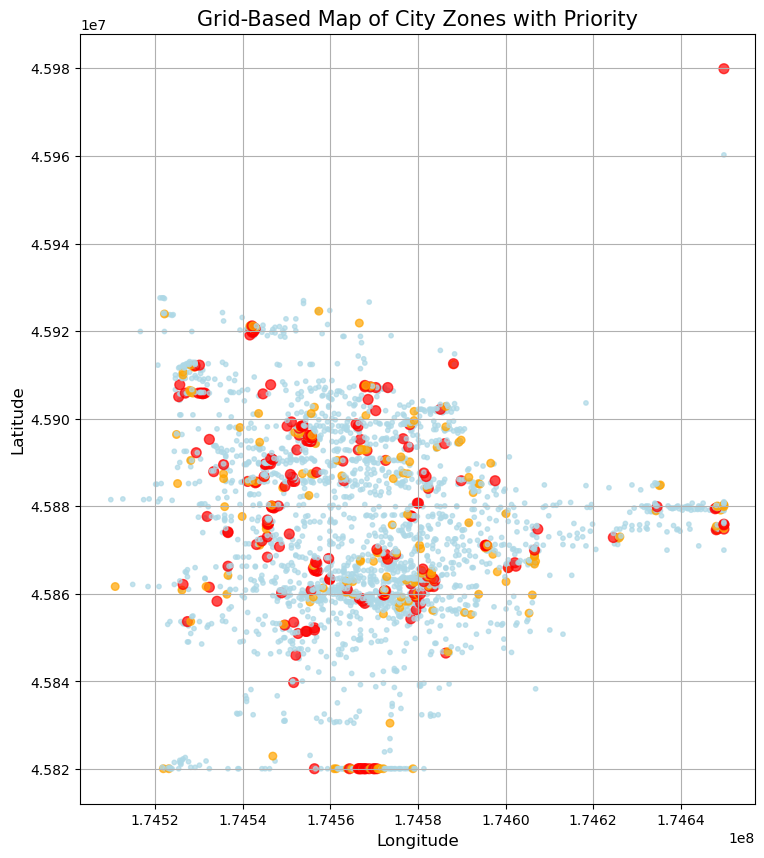

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Create GeoDataFrame from your DataFrame
city_zones_df['geometry'] = city_zones_df.apply(lambda x: Point(x['lng'], x['lat']), axis=1)
gdf = gpd.GeoDataFrame(city_zones_df, geometry='geometry')

# Define a color map and priority for different zones
color_map = {
    'Center': 'red',
    'Nearby': 'orange',
    'Far': 'lightblue'
}

priority_map = {
    'Center': 1,
    'Nearby': 2,
    'Far': 3
}

# Assign colors and priorities based on the zone
gdf['color'] = gdf['zone'].map(color_map)
gdf['priority'] = gdf['zone'].map(priority_map)

# Define marker sizes based on zone
size_map = {
    'Center': 50,  # Larger size for 'Center'
    'Nearby': 30,  # Medium size for 'Nearby'
    'Far': 10      # Smaller size for 'Far'
}

# Assign sizes based on the zone
gdf['size'] = gdf['zone'].map(size_map)

# Keep only the highest priority zones
highest_priority_zones = gdf.loc[gdf.groupby(['lat', 'lng'])['priority'].idxmin()]

# Plot the zones
fig, ax = plt.subplots(figsize=(10, 10))
highest_priority_zones.plot(ax=ax, color=highest_priority_zones['color'], 
                             markersize=highest_priority_zones['size'], alpha=0.7)

# Add titles and labels
plt.title('Grid-Based Map of City Zones with Priority', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()

# Show the plot
plt.show()




In [17]:
# Filter only the "Center" zones from city_zones_df
center_zones_df = city_zones_df[city_zones_df['zone'] == 'Center']

# Function to generate a random position from the center zones
def generate_random_position_from_center(center_zones_df):
    # Randomly select a "Center" zone
    random_zone = center_zones_df.sample(n=1).iloc[0]
    
    # Define latitude and longitude boundaries based on the grid size
    lat_min = random_zone['lat'] - (grid_size / 2)
    lat_max = random_zone['lat'] + (grid_size / 2)
    lng_min = random_zone['lng'] - (grid_size / 2)
    lng_max = random_zone['lng'] + (grid_size / 2)
    
    # Generate random latitude and longitude within the boundaries of the selected zone
    random_lat = np.random.uniform(lat_min, lat_max)
    random_lng = np.random.uniform(lng_min, lng_max)
    
    return random_lat, random_lng

# Apply the random position generator to assign positions to couriers using only "Center" zones
courier_availability[['courier_lat', 'courier_lng']] = courier_availability.apply(
    lambda row: pd.Series(generate_random_position_from_center(center_zones_df)),
    axis=1
)

In [14]:

# Helper function to convert date and hour to Unix timestamp
def to_unix_timestamp(date_str, hour):
    dt_str = f"{date_str} {hour}:00"
    dt_obj = datetime.strptime(dt_str, '%Y-%m-%d %H:%M')
    return int(dt_obj.timestamp())

def convert_to_unix_timestamps(courier_availability):
    # Create Unix timestamp columns for min_order_push_hour and max_arrive_hour
    courier_availability['min_order_push_unix'] = courier_availability.apply(
        lambda row: to_unix_timestamp(row['date'], row['min_order_push_hour']), axis=1
    )
    
    courier_availability['max_arrive_unix'] = courier_availability.apply(
        lambda row: to_unix_timestamp(row['date'], row['max_arrive_hour']), axis=1
    )

    return courier_availability


# Helper function to convert date and time to Unix timestamp
def second_to_unix_timestamp(date_str, time_str=None):
    if time_str:
        combined_str = f"{date_str} {time_str}"
        dt_obj = datetime.strptime(combined_str, '%Y-%m-%d %H:%M')
    else:
        dt_obj = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt_obj.timestamp())

# Convert order positions to Unix timestamps
def convert_order_positions_to_unix(order_positions_df):
    # Create Unix timestamp for the order time
    order_positions_df['order_time_unix'] = order_positions_df.apply(
        lambda row: second_to_unix_timestamp(row['platform_order_day'], row['platform_order_time_formatted']), axis=1
    )
    
    return order_positions_df


# Convert to Unix timestamps
courier_availability = convert_to_unix_timestamps(courier_availability)
order_positions_df = convert_order_positions_to_unix(order_positions_df)


def convert_coordinates(df, lat_column, lng_column):
    """
    Convert microcoordinates in the given dataframe to degrees and store them in new columns.
    """
    df[lat_column] = df[lat_column] / 1000000
    df[lng_column] = df[lng_column] / 1000000
    return df

# Convert courier_availability coordinates
courier_availability = convert_coordinates(courier_availability, 'courier_lat', 'courier_lng')

# Convert order_positions_df coordinates
order_positions_df = convert_coordinates(order_positions_df, 'order_start_lat', 'order_start_lng')
order_positions_df = convert_coordinates(order_positions_df, 'order_end_lat', 'order_end_lng')

city_zones_df = convert_coordinates(city_zones_df,'lat','lng')


/tmp/ipykernel_846/487078122.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_positions_df['order_time_unix'] = order_positions_df.apply(


KeyError: 'courier_lat'

In [14]:

# Random Order Data from Order Positions
random_order_positions_df = order_positions_df.sample(n=100, random_state=42)
# Sort the DataFrame by the 'order_time_unix' column in ascending order
random_order_positions_df = random_order_positions_df.sort_values(by='order_time_unix', ascending=True)

# Reset the index of the sorted DataFrame
random_order_positions_df.reset_index(drop=True, inplace=True)

print(random_order_positions_df.head())

   order_id  order_start_lat  order_start_lng  order_end_lat  order_end_lng  \
0    493434        46.056274       174.951199      46.042858     174.928932   
1    315761        45.872960       174.545650      45.880788     174.549996   
2    153056        45.874288       174.647503      45.875341     174.633311   
3    373814        45.880118       174.547076      45.871507     174.539996   
4     95437        46.052237       174.943713      46.053611     174.946502   

  platform_order_day platform_order_time_formatted  order_time_unix  
0         2022-10-17                         03:06       1665968760  
1         2022-10-17                         03:29       1665970140  
2         2022-10-17                         03:29       1665970140  
3         2022-10-17                         03:32       1665970320  
4         2022-10-17                         04:02       1665972120  


In [15]:
print(courier_availability.head())

   courier_id        date  min_order_push_hour  max_arrive_hour  \
0           0  2022-10-17                    0                5   
1           0  2022-10-18                    0               11   
2           0  2022-10-20                    0                7   
3           0  2022-10-23                    0                4   
4           1  2022-10-16                    0               15   

  courier_vehicle_type  WLTP_CO2_emissions  courier_lat  courier_lng  \
0              Bicycle                0.00    45.871452   174.596020   
1              Bicycle                0.00    45.892346   174.568018   
2              Bicycle                0.00    45.861161   174.572680   
3              Bicycle                0.00    45.896002   174.552420   
4    FIAT GROUP PETROL              133.18    45.884032   174.582646   

   min_order_push_unix  max_arrive_unix  
0           1665957600       1665975600  
1           1666044000       1666083600  
2           1666216800       166624200

In [16]:
########## Fastest Vehicle Model #############

# Function to print current memory usage
def print_memory_usage(stage):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"[{stage}] Memory usage: {mem_info.rss / (1024 * 1024):.2f} MB")

# Traffic delay factors based on zones
TRAFFIC_FACTORS = {
    'Center': 1.8,
    'Nearby': 1.55,
    'Far': 1.25
}

# Daytime hours (traffic delay applied during these hours)
DAYTIME_START = 8  # 8:00 AM
DAYTIME_END = 22  # 10:00 PM

# Speed Definition for Cars and Bicycles
car_speed = 30
bicycle_speed = 15

# Function to return traffic delay factor based on the zone
def traffic_delay_factor(zone):
    return TRAFFIC_FACTORS.get(zone, 1.0)

# Function to find the nearest zone for given latitude and longitude
def find_nearest_zone(lat, lng, city_zones_df):
    city_zones_df['distance'] = ((city_zones_df['lat'] - lat) ** 2 + (city_zones_df['lng'] - lng) ** 2) ** 0.5
    nearest_zone = city_zones_df.loc[city_zones_df['distance'].idxmin()]['zone']
    return nearest_zone

# Helper function to calculate delivery times using speed and distance
def calculate_delivery_time(distance, speed_kmh):
    return distance / speed_kmh

# Haversine distance calculation function
def haversine_distance(lat1, lon1, lat2, lon2):
    import math
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Environmental impact calculation function
def calculate_environmental_impact(distance_km, co2_emissions_per_km):
    if co2_emissions_per_km == 0:
        return 0.0  # No emissions for zero-emission vehicles or bicycles
    else:
        return distance_km * co2_emissions_per_km

# Function to calculate the traffic-adjusted distance for a segment based on its zone
def apply_segment_traffic_factor(lat1, lng1, lat2, lng2, vehicle_type, city_zones_df, order_time_unix):
    order_time = datetime.utcfromtimestamp(order_time_unix)
    order_hour = order_time.hour

    if order_hour < DAYTIME_START or order_hour >= DAYTIME_END:
        return haversine_distance(lat1, lng1, lat2, lng2)
    
    distance = haversine_distance(lat1, lng1, lat2, lng2)

    if vehicle_type != 'Bicycle':
        zone_1 = find_nearest_zone(lat1, lng1, city_zones_df)
        zone_2 = find_nearest_zone(lat2, lng2, city_zones_df)
        traffic_factor_1 = traffic_delay_factor(zone_1)
        traffic_factor_2 = traffic_delay_factor(zone_2)
        segment_traffic_factor = (traffic_factor_1 + traffic_factor_2) / 2
        distance *= segment_traffic_factor
    
    return distance

# Function to process orders for each day in a process (for multiprocessing)
def process_orders_for_day(order_positions_day, courier_availability, city_zones_df):
    result_df = assign_couriers_to_orders(order_positions_day, courier_availability, city_zones_df)
    return result_df

# Main courier selection function
def assign_couriers_to_orders(order_positions_df, courier_availability, city_zones_df):
    results = []
    courier_availabilities = {}

    # Memory tracking before processing orders
    print_memory_usage("Before processing orders")

    for _, order in order_positions_df.iterrows():
        order_time_unix = order['order_time_unix']  # This is the order start time

        available_couriers = courier_availability[
            (courier_availability['min_order_push_unix'] <= order_time_unix) &
            (courier_availability['max_arrive_unix'] >= order_time_unix)
        ]
        
        # Initialize variables for the fastest courier
        fastest_courier = None
        min_total_time = float('inf')
        best_total_road_distance_with_traffic = float('inf')
        best_total_road_distance_no_traffic = float('inf')
        best_vehicle_type = None
        best_environmental_impact = float('inf')
        
        order_start_lat = order['order_start_lat']
        order_start_lng = order['order_start_lng']
        order_end_lat = order['order_end_lat']
        order_end_lng = order['order_end_lng']
        
        available_couriers = available_couriers.copy()

        # Calculate the distance to the order for each courier
        available_couriers.loc[:, 'distance_to_order'] = available_couriers.apply(
            lambda courier: haversine_distance(
                courier['courier_lat'], courier['courier_lng'], 
                order_start_lat, order_start_lng
            ), axis=1
        )

        # Filter couriers within 10 km
        available_couriers_in_range = available_couriers[available_couriers['distance_to_order'] <= 10]
        # If no couriers are available within 10 km, mark the order as unassigned
        if available_couriers_in_range.empty:
            results.append({
                'order_id': order['order_id'],
                'courier_id': None,
                'total_delivery_time_hours': None,
                'courier_available_at_unix': None,
                'road_distance_no_traffic_km': None,
                'road_distance_with_traffic_km': None,
                'vehicle_type': None,
                'environmental_impact_kg_CO2': None,
                'order_start_time_unix': order_time_unix,  # Add order start time
                'order_end_time_unix': None,  # No end time since no courier is assigned
                'assignment_status': 'there are no available couriers'
            })
            continue  # Skip to the next order

        # If couriers are available in range, proceed with the existing logic
        for _, courier in available_couriers_in_range.iterrows():
            courier_id = courier['courier_id']

            if courier_id in courier_availabilities:
                courier_start_lat = courier_availabilities[courier_id]['lat']
                courier_start_lng = courier_availabilities[courier_id]['lng']
                courier_available_at = courier_availabilities[courier_id]['available_at']
            else:
                courier_start_lat = courier['courier_lat']
                courier_start_lng = courier['courier_lng']
                courier_available_at = order_time_unix

            if courier_available_at > order_time_unix:
                continue

            vehicle_type = courier['courier_vehicle_type']
            co2_emissions_per_km = courier['WLTP_CO2_emissions']

            # Calculate the distances without traffic (base road distance)
            courier_to_order_dist_no_traffic = haversine_distance(
                courier_start_lat, courier_start_lng, 
                order_start_lat, order_start_lng
            )
            
            order_to_delivery_dist_no_traffic = haversine_distance(
                order_start_lat, order_start_lng, 
                order_end_lat, order_end_lng
            )

            total_road_distance_no_traffic = courier_to_order_dist_no_traffic + order_to_delivery_dist_no_traffic

            # Calculate the distances with traffic delay for each segment
            courier_to_order_dist_with_traffic = apply_segment_traffic_factor(
                courier_start_lat, courier_start_lng, 
                order_start_lat, order_start_lng, 
                vehicle_type, city_zones_df, order_time_unix
            )
            
            order_to_delivery_dist_with_traffic = apply_segment_traffic_factor(
                order_start_lat, order_start_lng, 
                order_end_lat, order_end_lng, 
                vehicle_type, city_zones_df, order_time_unix
            )

            total_road_distance_with_traffic = courier_to_order_dist_with_traffic + order_to_delivery_dist_with_traffic

            if vehicle_type == 'Bicycle':
                speed_kmh = bicycle_speed
            else:
                speed_kmh = car_speed

            courier_to_order_time = calculate_delivery_time(courier_to_order_dist_with_traffic, speed_kmh)
            order_to_delivery_time = calculate_delivery_time(order_to_delivery_dist_with_traffic, speed_kmh)
            total_delivery_time = courier_to_order_time + order_to_delivery_time

            # Calculate the environmental impact for the trip
            total_environmental_impact = calculate_environmental_impact(
                total_road_distance_no_traffic, co2_emissions_per_km
            )

            if total_delivery_time < min_total_time:
                min_total_time = total_delivery_time
                fastest_courier = courier
                best_total_road_distance_with_traffic = total_road_distance_with_traffic
                best_total_road_distance_no_traffic = total_road_distance_no_traffic
                best_vehicle_type = vehicle_type
                best_environmental_impact = total_environmental_impact

        # If a courier is assigned, update their availability and log the result
        if fastest_courier is not None and not fastest_courier.empty:
            courier_id = fastest_courier['courier_id']
            order_end_time_unix = order_time_unix + int(min_total_time * 3600)  # Calculating order end time

            courier_availabilities[courier_id] = {
                'available_at': order_end_time_unix,
                'lat': order['order_end_lat'],
                'lng': order['order_end_lng']
            }

            results.append({
                'order_id': order['order_id'],
                'courier_id': courier_id,
                'total_delivery_time_hours': min_total_time,
                'courier_available_at_unix': order_end_time_unix,
                'road_distance_no_traffic_km': best_total_road_distance_no_traffic,
                'road_distance_with_traffic_km': best_total_road_distance_with_traffic,
                'vehicle_type': best_vehicle_type,
                'environmental_impact_kg_CO2': best_environmental_impact,
                'order_start_time_unix': order_time_unix,  # Add order start time
                'order_end_time_unix': order_end_time_unix,  # Add order end time
                'assignment_status': 'Order assigned'
            })

    print_memory_usage("After processing orders")

    fastest_car_results_df = pd.DataFrame(results)
    return fastest_car_results_df

# Main function to run processes for each day
def run_model_with_multiprocessing(order_positions_df, courier_availability, city_zones_df):
    # Split the order_positions_df by day
    days = order_positions_df['platform_order_day'].unique()
    pool = mp.Pool(mp.cpu_count())  # Create a pool of workers
    results = pool.starmap(process_orders_for_day, [(order_positions_df[order_positions_df['platform_order_day'] == day], courier_availability, city_zones_df) for day in days])
    pool.close()
    pool.join()

    # Combine results
    fastest_car_results_df = pd.concat(results, ignore_index=True)
    return fastest_car_results_df

# Example usage with multiprocessing
fastest_car_results_df = run_model_with_multiprocessing(random_order_positions_df, courier_availability, city_zones_df)
print(fastest_car_results_df.head())

# Save the random_order_positions_df as CSV to a Windows directory
#windows_path = '/mnt/c/Users/baris/Downloads/fastest_vehicle_model_results.csv'
#results_df.to_csv(windows_path, index=False)


[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.42 MB
[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.36 MB
[Before processing orders] Memory usage: 525.36 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
[After processing orders] Memory usage: 528.46 MB
   order_id  courier_id  total_delivery_time_hours  courier_available_at_unix  \
0    493434         NaN                        NaN                        NaN   
1    315761     21851.0       

In [17]:
########## DataPillars Environmentally Friendly Courier Delivery Model #############

# Function to print current memory usage
def print_memory_usage(stage):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"[{stage}] Memory usage: {mem_info.rss / (1024 * 1024):.2f} MB")

# Traffic delay factors based on zones
TRAFFIC_FACTORS = {
    'Center': 1.8,
    'Nearby': 1.55,
    'Far': 1.25
}

# Daytime hours (traffic delay applied during these hours)
DAYTIME_START = 8  # 8:00 AM
DAYTIME_END = 22  # 10:00 PM

# Time thresholds (minutes to hours)
BICYCLE_TIME_THRESHOLD = 6 / 60  # 6 minutes in hours
ENVIRONMENTAL_TIME_THRESHOLD = 3 / 60  # 3 minutes in hours

# Speed Definition for Cars and Bicycles
car_speed = 30
bicycle_speed = 15

# Function to return traffic delay factor based on the zone
def traffic_delay_factor(zone):
    return TRAFFIC_FACTORS.get(zone, 1.0)

# Function to find the nearest zone for given latitude and longitude
def find_nearest_zone(lat, lng, city_zones_df):
    city_zones_df['distance'] = ((city_zones_df['lat'] - lat) ** 2 + (city_zones_df['lng'] - lng) ** 2) ** 0.5
    nearest_zone = city_zones_df.loc[city_zones_df['distance'].idxmin()]['zone']
    return nearest_zone

# Helper function to calculate delivery times using speed and distance
def calculate_delivery_time(distance, speed_kmh):
    return distance / speed_kmh

# Haversine distance calculation function
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Environmental impact calculation function
def calculate_environmental_impact(distance_km, co2_emissions_per_km):
    if co2_emissions_per_km == 0:
        return 0.0  # No emissions for zero-emission vehicles or bicycles
    else:
        return distance_km * co2_emissions_per_km

# Function to calculate the traffic-adjusted distance for a segment based on its zone
def apply_segment_traffic_factor(lat1, lng1, lat2, lng2, vehicle_type, city_zones_df, order_time_unix):
    order_time = datetime.utcfromtimestamp(order_time_unix)
    order_hour = order_time.hour

    if order_hour < DAYTIME_START or order_hour >= DAYTIME_END:
        return haversine_distance(lat1, lng1, lat2, lng2)
    
    distance = haversine_distance(lat1, lng1, lat2, lng2)

    if vehicle_type != 'Bicycle':
        zone_1 = find_nearest_zone(lat1, lng1, city_zones_df)
        zone_2 = find_nearest_zone(lat2, lng2, city_zones_df)
        traffic_factor_1 = traffic_delay_factor(zone_1)
        traffic_factor_2 = traffic_delay_factor(zone_2)
        segment_traffic_factor = (traffic_factor_1 + traffic_factor_2) / 2
        distance *= segment_traffic_factor
    
    return distance

# Function to process orders for each day in a process (for multiprocessing)
def process_orders_for_day(order_positions_day, courier_availability, city_zones_df):
    result_df = assign_couriers_to_orders(order_positions_day, courier_availability, city_zones_df)
    return result_df

def assign_couriers_to_orders(order_positions_df, courier_availability, city_zones_df):
    results = []
    courier_availabilities = {}

    # Memory tracking before processing orders
    print_memory_usage("Before processing orders")

    for _, order in order_positions_df.iterrows():
        order_time_unix = order['order_time_unix']  # This will be the order start time (order_start_time_unix)

        available_couriers = courier_availability[
            (courier_availability['min_order_push_unix'] <= order_time_unix) &
            (courier_availability['max_arrive_unix'] >= order_time_unix)
        ]

        # Check for couriers within a 10 km range
        order_start_lat = order['order_start_lat']
        order_start_lng = order['order_start_lng']
        available_couriers = available_couriers.copy()

        # Filter couriers within a 10 km range using .loc
        couriers_in_range = available_couriers[
            available_couriers.apply(
                lambda x: haversine_distance(x['courier_lat'], x['courier_lng'], order_start_lat, order_start_lng) <= 10, 
                axis=1
            )
        ]

        if couriers_in_range.empty:
            # No available couriers in range
            results.append({
                'order_id': order['order_id'],
                'courier_id': None,
                'total_delivery_time_hours': None,
                'courier_available_at_unix': None,
                'road_distance_no_traffic_km': None,
                'road_distance_with_traffic_km': None,
                'vehicle_type': None,
                'environmental_impact_kg_CO2': None,
                'order_start_time_unix': order_time_unix,
                'order_end_time_unix': None,
                'Order assigned': "There are no available couriers"
            })
            continue  # Move to the next order

        fastest_courier = None
        min_total_time = float('inf')
        fastest_bicycle_courier = None
        min_bicycle_time = float('inf')
        least_environmental_impact_courier = None
        min_environmental_impact_time = float('inf')
        min_environmental_impact_value = float('inf')

        # Step 1: Find the fastest courier (assign them first)
        for _, courier in couriers_in_range.iterrows():
            courier_id = courier['courier_id']

            if courier_id in courier_availabilities:
                courier_start_lat = courier_availabilities[courier_id]['lat']
                courier_start_lng = courier_availabilities[courier_id]['lng']
                courier_available_at = courier_availabilities[courier_id]['available_at']
            else:
                courier_start_lat = courier['courier_lat']
                courier_start_lng = courier['courier_lng']
                courier_available_at = order_time_unix

            if courier_available_at > order_time_unix:
                continue

            order_end_lat = order['order_end_lat']
            order_end_lng = order['order_end_lng']
            vehicle_type = courier['courier_vehicle_type']
            co2_emissions_per_km = courier['WLTP_CO2_emissions']

            # Calculate the distances (no traffic)
            courier_to_order_dist_no_traffic = haversine_distance(
                courier_start_lat, courier_start_lng, 
                order_start_lat, order_start_lng
            )
            
            order_to_delivery_dist_no_traffic = haversine_distance(
                order_start_lat, order_start_lng, 
                order_end_lat, order_end_lng
            )

            total_road_distance_no_traffic = courier_to_order_dist_no_traffic + order_to_delivery_dist_no_traffic

            # Calculate traffic-adjusted distances
            courier_to_order_dist_with_traffic = apply_segment_traffic_factor(
                courier_start_lat, courier_start_lng, 
                order_start_lat, order_start_lng, 
                vehicle_type, city_zones_df, order_time_unix
            )
            
            order_to_delivery_dist_with_traffic = apply_segment_traffic_factor(
                order_start_lat, order_start_lng, 
                order_end_lat, order_end_lng, 
                vehicle_type, city_zones_df, order_time_unix
            )

            total_road_distance_with_traffic = courier_to_order_dist_with_traffic + order_to_delivery_dist_with_traffic

            if vehicle_type == 'Bicycle':
                speed_kmh = 15
            else:
                speed_kmh = 30

            courier_to_order_time = calculate_delivery_time(courier_to_order_dist_with_traffic, speed_kmh)
            order_to_delivery_time = calculate_delivery_time(order_to_delivery_dist_with_traffic, speed_kmh)
            total_delivery_time = courier_to_order_time + order_to_delivery_time

            # Calculate the environmental impact using the non-traffic road distance
            total_environmental_impact = calculate_environmental_impact(
                total_road_distance_no_traffic, co2_emissions_per_km
            )

            # Track the fastest courier
            if total_delivery_time < min_total_time:
                min_total_time = total_delivery_time
                fastest_courier = courier

            # Track the fastest bicycle courier
            if vehicle_type == 'Bicycle' and total_delivery_time < min_bicycle_time:
                min_bicycle_time = total_delivery_time
                fastest_bicycle_courier = courier

            # Track the least environmentally impactful courier
            if vehicle_type != 'Bicycle' and total_environmental_impact < min_environmental_impact_value:
                min_environmental_impact_time = total_delivery_time
                least_environmental_impact_courier = courier
                min_environmental_impact_value = total_environmental_impact

        # Step 2: Start with the fastest courier
        chosen_courier = fastest_courier

        # Step 3: Now evaluate other couriers based on predefined conditions
        # Select bicycle if within 6 minutes of the fastest
        if fastest_bicycle_courier is not None and min_bicycle_time <= min_total_time + BICYCLE_TIME_THRESHOLD:
            chosen_courier = fastest_bicycle_courier

        # Select environmentally friendly courier if within 3 minutes of the fastest
        elif least_environmental_impact_courier is not None and min_environmental_impact_time <= min_total_time + ENVIRONMENTAL_TIME_THRESHOLD:
            chosen_courier = least_environmental_impact_courier

        # Recalculate final road distances, delivery time, and environmental impact
        if chosen_courier is not None:
            final_courier_to_order_dist_no_traffic = haversine_distance(
                chosen_courier['courier_lat'], chosen_courier['courier_lng'],
                order['order_start_lat'], order['order_start_lng']
            )
            final_order_to_delivery_dist_no_traffic = haversine_distance(
                order['order_start_lat'], order['order_start_lng'],
                order['order_end_lat'], order['order_end_lng']
            )
            total_road_distance_no_traffic = final_courier_to_order_dist_no_traffic + final_order_to_delivery_dist_no_traffic

            final_courier_to_order_dist_with_traffic = apply_segment_traffic_factor(
                chosen_courier['courier_lat'], chosen_courier['courier_lng'],
                order['order_start_lat'], order['order_start_lng'], 
                chosen_courier['courier_vehicle_type'], city_zones_df, order_time_unix
            )
            final_order_to_delivery_dist_with_traffic = apply_segment_traffic_factor(
                order['order_start_lat'], order['order_start_lng'],
                order['order_end_lat'], order['order_end_lng'], 
                chosen_courier['courier_vehicle_type'], city_zones_df, order_time_unix
            )
            total_road_distance_with_traffic = final_courier_to_order_dist_with_traffic + final_order_to_delivery_dist_with_traffic

            # Environmental impact is already calculated using the non-traffic distance
            final_environmental_impact = calculate_environmental_impact(
                total_road_distance_no_traffic, chosen_courier['WLTP_CO2_emissions']
            )

            # Recalculate total delivery time based on the chosen courier
            if chosen_courier['courier_vehicle_type'] == 'Bicycle':
                speed_kmh = bicycle_speed
            else:
                speed_kmh = car_speed

            courier_to_order_time = calculate_delivery_time(final_courier_to_order_dist_with_traffic, speed_kmh)
            order_to_delivery_time = calculate_delivery_time(final_order_to_delivery_dist_with_traffic, speed_kmh)
            total_delivery_time = courier_to_order_time + order_to_delivery_time

            # Update courier availability ONLY for the chosen courier
            order_end_time_unix = order_time_unix + int(total_delivery_time * 3600)
            
            # Ensure the chosen courier is marked as busy only after final decision
            courier_availabilities[chosen_courier['courier_id']] = {
                'available_at': order_end_time_unix,
                'lat': order['order_end_lat'],
                'lng': order['order_end_lng']
            }

            # Append the result for the chosen courier
            results.append({
                'order_id': order['order_id'],
                'courier_id': chosen_courier['courier_id'],
                'total_delivery_time_hours': total_delivery_time,
                'courier_available_at_unix': order_end_time_unix,
                'road_distance_no_traffic_km': total_road_distance_no_traffic,
                'road_distance_with_traffic_km': total_road_distance_with_traffic,
                'vehicle_type': chosen_courier['courier_vehicle_type'],
                'environmental_impact_kg_CO2': final_environmental_impact,
                'order_start_time_unix': order_time_unix,
                'order_end_time_unix': order_end_time_unix,
                'Order assigned': "Successfully assigned"
            })

    # Memory tracking after processing orders
    print_memory_usage("After processing orders")
    return pd.DataFrame(results)

# Main function to run processes for each day
def run_model_with_multiprocessing(order_positions_df, courier_availability, city_zones_df):
    days = order_positions_df['platform_order_day'].unique()
    pool = mp.Pool(mp.cpu_count())  # Create a pool of workers
    results = pool.starmap(process_orders_for_day, [(order_positions_df[order_positions_df['platform_order_day'] == day], courier_availability, city_zones_df) for day in days])
    pool.close()
    pool.join()

    env_friend_results_df = pd.concat(results, ignore_index=True)
    return env_friend_results_df

# Example usage with multiprocessing
env_friend_results_df = run_model_with_multiprocessing(random_order_positions_df, courier_availability, city_zones_df)
print(env_friend_results_df.head())

# Save the results as CSV
#windows_path = '/mnt/c/Users/baris/Downloads/environmentally_friendly_model_results.csv'
#results_df.to_csv(windows_path, index=False)



[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[Before processing orders] Memory usage: 559.54 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
[After processing orders] Memory usage: 562.15 MB
   order_id  courier_id  total_delivery_time_hours  courier_available_at_unix  \
0    493434         NaN                        NaN                        NaN   
1    315761      7966.0       